# Recommendation Chatbot API: Evaluation

In [1]:
%%capture output
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

BASE_PATH    = '../..'
API_PATH     = f'{BASE_PATH}/chat-bot-api'
LIB_PATH     = f'{BASE_PATH}/lib'
DATASET_PATH = f'{BASE_PATH}/datasets'
METRICS_PATH = f'{BASE_PATH}/metrics'
EVAL_METRICS_PATH = f'{METRICS_PATH}/evaluation-metrics.dt'

os.environ['TMP_PATH']         = f'{BASE_PATH}/tmp'
os.environ['DATASET_PATH']     = f'{BASE_PATH}/datasets'
os.environ['WEIGHTS_PATH']     = f'{BASE_PATH}/weights'
os.environ['METRICS_PATH']     = f'{BASE_PATH}/metrics'

sys.path.append(LIB_PATH)
sys.path.append(API_PATH)

In [3]:
import logging
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

import pytorch_common.util as pu
import util as ut

import client
from faker import Faker

import metric as mt
from statistics import mean

from client import RecChatBotV1ApiClient

# Common Functions and Classes

In [4]:
def genres_count(interactions_test_set, items, user_id):
    df = interactions_test_set[interactions_test_set['user_id'] == user_id]

    item_ids = df['item_id'].unique()
    
    genres = []
    for item_id in item_ids:
        genres.extend(items[items['movie_id'] == item_id]['movie_genres'].tolist()[0])

    return pd.Series(genres).value_counts().reset_index(name='count')



def releases(interactions_test_set, items, user_id):
    df = interactions_test_set[interactions_test_set['user_id'] == user_id]

    return np.sort(items[items['movie_id'].isin(df['item_id'].unique())]['movie_release_year'].unique())

In [5]:
def create_fake_profiles(interactions_test_set, items):
    fake = Faker()

    to_email = lambda name: name.lower().replace(' ', '.') + '@gmail.com'

    user_ids = interactions_test_set['user_id'].unique()

    profiles = []
    emails   = []
    profile_user_ids = []
    for user_id in user_ids:        
        while True:
            name  = fake.name()
            email = to_email(name)
            if email not in emails:
                break

        profile_user_ids.append(user_id)
        emails.append(email)

        genres_count_df = genres_count(interactions_test_set, items, user_id=user_id)
        genres = genres_count_df[genres_count_df['count'] >= 10]['index'].tolist()
    
        release = str(releases(interactions_test_set, items, user_id=user_id)[0])
    
        profiles.append(client.UserProfileDto(
            name             = name,
            email            = email,
            preferred_from   = release,
            preferred_genres = genres
        ))

    logging.debug(f'Profiles: {len(profiles)}')
    logging.debug(f'Users: {len(user_ids)}')
    
    return profiles, profile_user_ids

In [6]:
def reset_env(
    api_client,
    interactions_test_set,
    items
):
    for profile in api_client.profiles():
        api_client.remove_interactions_by_user_id(profile.email)
        api_client.delete_profile(profile.email)

    profiles, user_ids = create_fake_profiles(interactions_test_set, items)

    [api_client.add_profile(profile) for profile in profiles]

    return profiles, user_ids

In [7]:
class RecQueryBuilder:
    def __init__(self, settings):
        self.settings = settings

    def user(self, value):
        self.user_id = value
        return self

    def prompt(self, value):
        self.prompt = value
        return self

    def build(self):
        return {
            'message': {
                'author': self.user_id,
                'content': self.prompt
            },
            'settings': self.settings
        }

In [8]:
def smooth_lineplot(
    x, 
    y,
    smooth_level              = 0.7,
    confidence_interval_alpha = 0.15,
    label                     = ''
):
    y_smooth = gaussian_filter1d(
        y,
        sigma = smooth_level
    )

    error = np.abs(y_smooth - y)

    sns.lineplot(
        x     = x,
        y     = y_smooth,
        label = label
    )
    plt.fill_between(
        x, 
        y_smooth - error, 
        y_smooth + error, 
        alpha = confidence_interval_alpha
    )

In [9]:
def plot_mean_ndgc_evolution(
    values, 
    smooth_level = 2,
    figsize      = (5,3)
):
    sns.set_style("whitegrid")
    plt.figure(figsize=figsize)
    
    smooth_lineplot(
        x                         = list(range(1, len(values)+1)),
        y                         = values,
        smooth_level              = smooth_level
    )
    
    plt.xlabel("Session step")
    plt.ylabel("Mean user NDGC")
    plt.title("Mean user NDGC by session step")


def plot_ndcg_sessions(
    ndcgs_by_sessions_size,
    smooth_level = 0.8,
    figsize      =(14, 5)
):
    plt.figure(figsize=figsize)

    for size, ndcgs in sorted(ndcgs_by_sessions_size.items()):
        smooth_lineplot(
            x                         = list(range(1, len(ndcgs)+1)),
            y                         = ndcgs,
            label                     = f'{size} Session steps)',
            smooth_level              = smooth_level
        )
    
    plt.xlabel("Session step")
    plt.ylabel("Mean user NDGC")
    plt.title("Mean user NDGC by session step")
    plt.legend()


def plot_n_users_by_session_evolution_size(
    users_by_sessions_size,
    figsize =(5 ,4)
):
    plt.figure(figsize=figsize)
    ax = sns.barplot(
        x = [i[0] for i in users_by_sessions_size], 
        y = [i[1] for i in users_by_sessions_size], 
        estimator="sum"
    )
    ax.bar_label(ax.containers[0], fontsize=10);
    plt.xlabel("Sessions steps")
    plt.ylabel("Users Count")
    plt.title("Users count by sessions steps")

In [10]:
@ut.printable
class SessionStep:
    def __init__(self, data): self.data = data

    @property
    def recommended_item_ids(self): return [int(id) for id in self.data['recommended_items']]

    @property
    def relevant_item_ids(self): return [int(id) for id in self.data['relevant_item_ratings'].keys()]

    @property
    def recall(self): return np.array(mt.recall(self.recommended_item_ids, self.relevant_item_ids))

    def relevante_rating(self, item_id): return self.data['relevant_item_ratings'][item_id]

    def _state(self): return self.data

    @property
    def ndcg(self):
        ordered_user_asigned_ratings = []
        for item_id in self.recommended_item_ids:
            if item_id in self.relevant_item_ids:
                ordered_user_asigned_ratings.append(self.relevante_rating(item_id))

        return mt.ndcg(ordered_user_asigned_ratings)

In [11]:
@ut.printable
@ut.iterable_object
class Session:
    def __init__(self, steps=[]):
        self.steps = []
        self.reset()
        [self.append(s) for s in steps]

    def append(self, step):
        self.steps.append(step if type(step) == SessionStep else SessionStep(step))

    @property
    def mean_reciprocal_rank(self):
        return mt.mean_reciprocal_rank(
            [s.recommended_item_ids for s in self.steps],   
            [s.relevant_item_ids for s in self.steps]
        )

    @property
    def mean_average_precision(self):
        return mt.mean_average_precision(
            [s.recommended_item_ids for s in self.steps],   
            [s.relevant_item_ids for s in self.steps]
        )

    @property
    def mean_recall(self): return np.stack([s.recall for s in self.steps]).mean()

    @property
    def recommended_item_ids(self): return [c.recommended_item_ids for c in self.steps]

    def catalog_coverage(self, item_ids): return mt.catalog_coverage(self.recommended_item_ids, item_ids)

    def _state(self): return self.steps

    def _elements(self): return self._state()
    
    @property
    def steps_ndcg(self): return [s.ndcg for s in self.steps]

In [12]:
@ut.printable
@ut.iterable_object
class SessionsGroup:
    def __init__(self, sessions=[]):
        self.sessions = []
        self.reset()
        [self.append(s) for s in sessions]


    def append(self, session): self.sessions.append(session if type(session) == Session else Session(step))


    def _state(self): return self.sessions


    def _elements(self): return self._state()


    @property
    def ndgc_evolution(self):
        sessions_ndgc = []

        max_steps = 0
        for session in self.sessions:
            if len(session) > max_steps:
                max_steps = len(session)
    
            sessions_ndgc.append(session.steps_ndcg)
    
        rows = []
        for values in sessions_ndgc:
            rows.append(
                np.pad(
                np.array(values), 
                (0, max_steps - len(values)), 
                mode            = 'constant', 
                constant_values = 0
            ))

        return np.array(rows)


    @property
    def mean_mean_reciprocal_rank(self):
        return np.mean([s.mean_reciprocal_rank for s in self.sessions])


    @property
    def mean_mean_average_precision(self):
        return np.mean([s.mean_average_precision for s in self.sessions])


    @property
    def mean_mean_recall(self):
        return np.mean([s.mean_recall for s in self.sessions])


    @property
    def mean_ndgc_evolution(self): return ut.nanmean(self.ndgc_evolution, axis=0)

    def catalog_coverage(self, item_ids):
        recommended_item_ids = []
        for s in self.sessions:
            recommended_item_ids.extend(s.recommended_item_ids) 
        
        return mt.catalog_coverage(recommended_item_ids, item_ids)

    @property
    def steps_by_index(self):
        groups = SessionStepDict()
        for session in self.sessions:
            for idx, step in enumerate(session):
                groups.put_step(idx+1, step)
        return groups

    
    @property
    def split_by_size(self):
        result = {}
        for session in self.sessions:
            sessions = result.get(len(session), SessionsGroup())
            sessions.append(session)
            result[len(session)] = sessions

        return dict(sorted(result.items()))

In [13]:
@ut.printable
class SessionStepDict:
    def __init__(self):
        self.session_by_key = {}

    def put_step(self, key, step):
        session = self.session_by_key.get(key, Session())
        session.append(step if type(step) == SessionStep else SessionStep(step))
        self.put_session(key, session)
        return self

    def put_session(self, key, session):
        self.session_by_key[key] = session if type(session) == Session else Session(step)
        return self

    def __getitem__(self, key): return self.session_by_key.get[key]

    @property
    def keys(self): return self.session_by_key.keys()

    @property
    def sessions(self): return SessionsGroup(self.session_by_key.values())

    @property
    def items(self): return self.session_by_key.items()
    
    @property
    def steps_count(self): return {key:len(session) for key, session in self.items}

    @property
    def step_ndgc(self):
        result = {}
        for key, session in self.items:    
            if key in result:
                result[key] = np.vstack((result[key], session.steps_ndcg))
            else:
                result[key] = np.array(session.steps_ndcg)

        return dict(sorted(result.items()))


    @property
    def step_mean_ndgc(self):
        return {key: ndcgs.mean() for key, ndcgs in self.step_ndgc.items()}
    
    def _state(self): return self.session_by_key

In [14]:
class EvaluationState:    
    @staticmethod
    def load(): return ut.Picket.load(EVAL_METRICS_PATH)


    @staticmethod
    def create(
        hyper_params,
        recomendation_size = 5,
        max_patience       = {
            40  : 2,
            100 : 3,
            200 : 4,
            300 : 5
        },
        plot_interval      = 10,
        verbose            = False
    ):
        if not os.path.exists(EVAL_METRICS_PATH):
            if not verbose: api_client.verbose_off
            profiles, user_ids  = reset_env(api_client, interactions_test_set, items)
            if not verbose: api_client.verbose_on

            return EvaluationState(
                recomendation_size,
                max_patience,
                plot_interval,            
                profiles, 
                user_ids, 
                hyper_params
            )
        else:
            return EvaluationState.load()


    def __init__(
        self,
        recomendation_size,
        max_patience,
        plot_interval,
        profiles,
        user_ids,
        hyper_params
    ):
        self.recomendation_size  = recomendation_size
        self.max_patience        = max_patience
        self.plot_interval       = plot_interval
        self.profiles            = profiles
        self.hyper_params        = hyper_params 
        
        self.profiles_by_user_id  = { u: p for p, u in zip(profiles, user_ids) }
        self.metrics_by_user_id  = {}

    def get_max_patience(self, size):
        last_patience = 1
        for patience_size, patience in self.max_patience.items():
            last_patience = patience
            if size <= patience_size:
                return patience
        return last_patience

    def save(self, path):
        ut.Picket.save(EVAL_METRICS_PATH, self)


    def find_profile_by_user_id(self, user_id):
        return self.profiles_by_user_id[user_id]


    def was_evaluated(self, user_id):
        return user_id in self.metrics_by_user_id


    def save_session(self, user_id, session):
        if user_id not in self.metrics_by_user_id:
            self.metrics_by_user_id[user_id] = []
        self.metrics_by_user_id.get(user_id).append(session)


    @property
    def session_steps_by_user(self):
        groups = SessionStepDict()
        for user_id, session in self.metrics_by_user_id.items():
            groups.put_session(user_id, Session(session))
        return groups


    def plot_metrics(self, item_ids=[]):
        plot_ndcg_sessions(
            {
                size: value.mean_ndgc_evolution
                for size, value in self.sessions.split_by_size.items()
            },
            smooth_level = 0.8,
            figsize      = (14, 6)
        )

        plot_mean_ndgc_evolution(
            self.sessions.mean_ndgc_evolution,
            smooth_level = 1,
            figsize      = (14, 6)
        )


        plot_n_users_by_session_evolution_size(
            [
                (n_steps, len(sessions))
                for n_steps, sessions in self.sessions.split_by_size.items()
            ],
            figsize      = (14, 4)
        )

        plt.show()

        logging.info(f'Mean Reciprocal Rank: {self.sessions.mean_mean_reciprocal_rank:.2}')
        logging.info(f'Mean Average Precision: {self.sessions.mean_mean_average_precision:.2}')
        logging.info(f'Recall: {self.sessions.mean_mean_recall:.2}')
        if len(item_ids) > 0:
            logging.info(f'Catalog Coverage: {self.sessions.catalog_coverage(item_ids):.2}')


    @property
    def sessions(self):
        return SessionsGroup([Session(steps) for steps in self.metrics_by_user_id.values()])

In [15]:
def sample(df, size): return df.sample(frac = 1).head(size)

def is_in(df1, left_col, df2, right_col): return df1[df1[left_col].isin(df2[right_col])]

def is_remaining(df, api_client, profile):
    user_voted_item_ids       = [int(i.item_id) for i in api_client.interactions_by_user(profile.email)]
    return df[~df['item_id'].isin(user_voted_item_ids)]

def n_items(df): return len(df["item_id"].unique())

def make_request(
    api_client,
    hyper_params,
    log_prefix,
    profile,
    remaining_items_sample
):
        titles = f'\n'.join([f'- {e}' for e in remaining_items_sample["movie_title"].values.tolist()])
        prompt = f'I want to see:\n{titles}'
    
        logging.debug(f'{log_prefix}Promp: {prompt}')

        return api_client.recommendations(
            RecQueryBuilder(hyper_params) \
                .user(profile.email) \
                .prompt(prompt) \
                .build() 
        ), prompt

In [16]:
from IPython.display import clear_output

class ModelEvaluator:
    def __init__(
        self,
        evaluation_state,
        interactions_test_set,
        items,
        path    = EVAL_METRICS_PATH,
        verbose = True
    ):
        self.evaluation_state           = evaluation_state
        self.interactions_by_user_id_df = interactions_test_set \
                    .sort_values(by=['timestamp']) \
                    .groupby(['user_id'])
        self.items        = items
        self.path         = path
        self.api_client   = client.RecChatBotV1ApiClient()
        self.api_item_ids = [int(item['id']) for item in self.api_client.items(all=True)]
        self.verbose      = verbose

    def run(self):
        user_ids = self.interactions_by_user_id_df.groups.keys()
        
        times = 1
        self.api_client.verbose_off
        for user_id in user_ids:
            profile  = self.evaluation_state.find_profile_by_user_id(user_id)
        
            log_prefix = f'{times}/{len(user_ids)} - {profile.email} - '
            if self.verbose:
                logging.info(f'{log_prefix}Begin user evaluation.')
        
            interactions_df = self.interactions_by_user_id_df.get_group((user_id,))
        
            patience = 0
            while True:
                remaining_interactions_df = interactions_df.pipe(is_remaining, self.api_client, profile)
        
                if self.evaluation_state.was_evaluated(user_id) and len(remaining_interactions_df) < self.evaluation_state.recomendation_size:
                    if self.verbose:
                        logging.info(f'{log_prefix}End evaluation. Less than {self.evaluation_state.recomendation_size} relevant items.')
                    break
        
                remaining_interactions_sample_df = remaining_interactions_df.pipe(sample, self.evaluation_state.recomendation_size)
                if len(remaining_interactions_sample_df) <= 1:
                    break
        
                remaining_items_sample = self.items.pipe(is_in, 'movie_id', remaining_interactions_sample_df, 'item_id')

                if self.verbose:
                    logging.info(f'{log_prefix}Sample: {len(remaining_items_sample)} - Remaining: {remaining_interactions_df.pipe(n_items)}/{len(interactions_df)}.')
        
                try:
                    result, prompt = make_request(
                        self.api_client,
                        self.evaluation_state.hyper_params,
                        log_prefix,
                        profile,
                        remaining_items_sample
                    )
                except client.NotFoundException as err:
                    if self.verbose:
                        logging.info(f'{log_prefix}End user evaluation. Retrain CF models to continue evaluation.')
                    break
                
                except Exception as err:
                    if self.verbose:
                        logging.error(f'{log_prefix}Api client error. Detail: {err}')
                    continue
                finally:
                    del remaining_items_sample
                
                rating_by_remaining_item_id = remaining_interactions_sample_df.pipe(ut.to_dict, 'item_id', 'rating')
                del remaining_interactions_sample_df

                result_relevent_items = list(filter(lambda x: int(x.id) in rating_by_remaining_item_id.keys(), result.items))

                if len(result_relevent_items) <= 1:
                    max_patience = self.evaluation_state.get_max_patience(len(remaining_interactions_df))

                    if patience >= max_patience:
                        if self.verbose:
                            logging.warning(f'{log_prefix}End user evaluation. {max_patience} max retries reached.')
                        break
        
                    patience += 1
                    if self.verbose:
                        logging.info(f'{log_prefix}Not found relevent items into recommendations(Patience: {patience}/{max_patience}).')
                    continue
                else:
                    patience = 0
                    if self.verbose:
                        logging.info(f'{log_prefix}Found {len(result_relevent_items)} relevant items into recommendations.')
        
                del remaining_interactions_df
        
                votes = []
                for item in result.items:
                    if int(item.id) in rating_by_remaining_item_id:
                        rating = rating_by_remaining_item_id[int(item.id)]
                        item.vote(rating)
                        votes.append(f'{int(item.id)}->{rating}')
                if self.verbose:
                    logging.info(f'{log_prefix}Votes: {", ".join(votes)}.')
                
                self.evaluation_state.save_session(
                    user_id,
                    session = {
                        'recommended_items'        : [item.id for item in result.items],
                        'recommended_item_ratings' : {int(item.id): item.rating for item in result.items},
                        'relevant_item_ratings'    : rating_by_remaining_item_id
                    }
                )
        
                del result
                del rating_by_remaining_item_id
        
            self.evaluation_state.save(self.path)

            if times % self.evaluation_state.plot_interval == 0:
                self.plot()

            times += 1
        
        self.api_client.verbose_on


    def plot(self):
        clear_output(wait=True)
        self.evaluation_state.plot_metrics(self.api_item_ids)

## Setup

In [17]:
def on_file(file_path, format='%(asctime)s - %(levelname)s - %(message)s'):
    handler = logging.FileHandler(file_path)
    handler.setFormatter(logging.Formatter(format))
    return handler


pu.LoggerBuilder() \
    .handler(on_file('./evaluation.log'))\
    .on_console() \
    .build()

<RootLogger root (INFO)>

**Step 1**: Load interactions test set and items data.

In [18]:
interactions_test_set = ut.load_df(f'{DATASET_PATH}/interactions_test_set.json')

In [19]:
items  = ut.load_df(f'{DATASET_PATH}/pre-processed-movies.json')

In [20]:
api_client = RecChatBotV1ApiClient()

api_client.health

2024-04-08 17:43:42,118 - INFO - GET http://nonosoft.ddns.net:8080/api/v1/health



{
    'chatbot_api': True,
    'ollama_api': True,
    'airflow': {'metadatabase': True, 'scheduler': True},
    'mongo_database': True,
    'choma_database': True
}

**Step 2**: Create evaluation state. 

* **EvaluationState** creates user profiles into **Chatbot API** from evaluation interactions.
* Register each user session data required to perform al evaluation metrics.
* Contains all data required to manage the evalauton process, like model hperparams, plot interval, etc..

In [21]:
evaluation_state = EvaluationState.create(
    recomendation_size = 5,
    max_patience       = {
        20  : 5,
        100 : 4,
        200 : 3,
        300 : 2
    },
    plot_interval      = 5,
    hyper_params       = {
        'llm'                                   : 'llama2-7b-chat',
        'retry'                                 : 3,
        'plain'                                 : False,
        'include_metadata'                      : True,
        'rag': {
            'shuffle'                           : False,
            'candidates_limit'                  : 100,
            'llm_response_limit'                : 100,
            'recommendations_limit'             : 10,
            'similar_items_augmentation_limit'  : 10,
            'not_seen'                          : True
        },
        'collaborative_filtering': {
            'shuffle'                           : False,
            'candidates_limit'                  : 50,
            'llm_response_limit'                : 50,
            'recommendations_limit'             : 10,
            'similar_items_augmentation_limit'  : 5,
            'text_query_limit'                  : 5000,
            'k_sim_users'                       : 10,
            'random_selection_items_by_user'    : 0.5,
            'max_items_by_user'                 : 10,
            'min_rating_by_user'                : 3.5,
            'not_seen'                          : True
        }
    }
)

**Step 3**: Perform chatbot API evaluation process.
* Simulate user interaciton with API.
* A user requests movie recommendations that previously has rated.
* It process register recomemndations with result rating and user rating.
* It data is user to perform all metrics.

In [22]:
evaluator = ModelEvaluator(
    evaluation_state, 
    interactions_test_set,
    items
)

2024-04-08 17:43:42,233 - INFO - GET http://nonosoft.ddns.net:8080/api/v1/items?email=&seen=True&content=&all=True&limit=5&hide_emb=True&release=1950&genres=


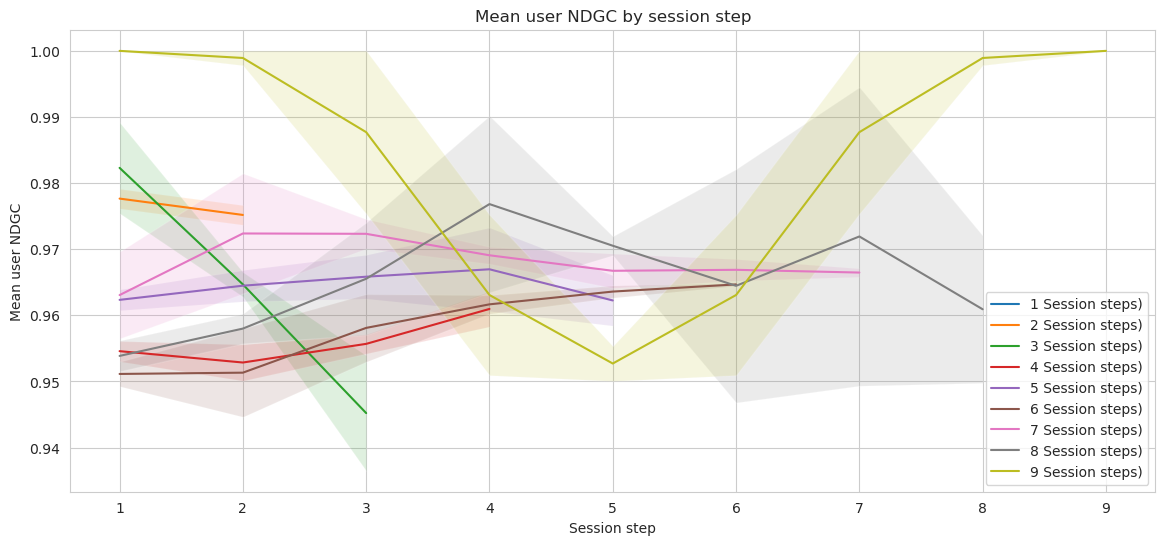

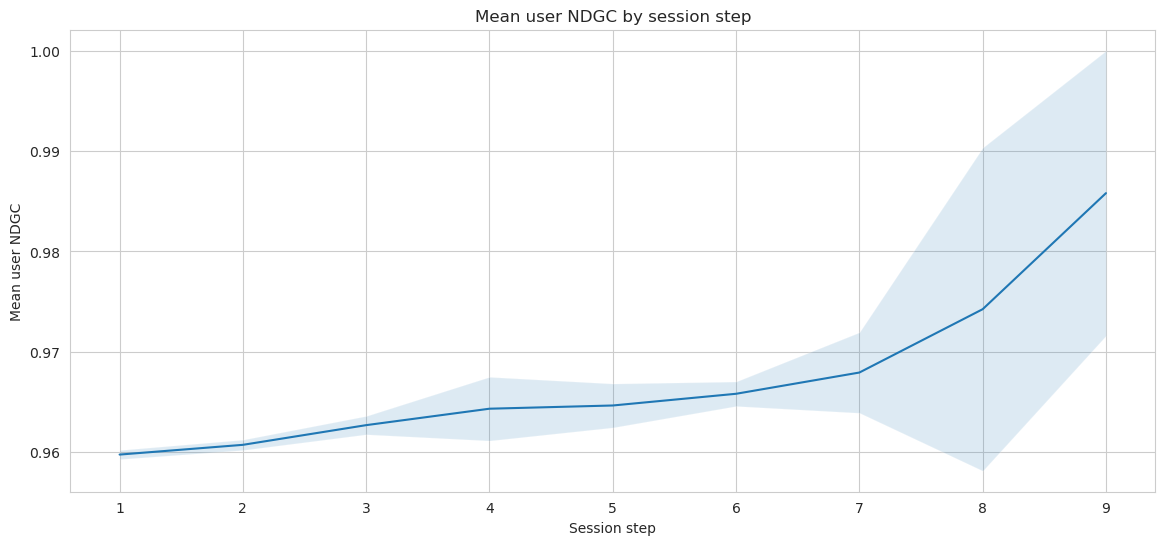

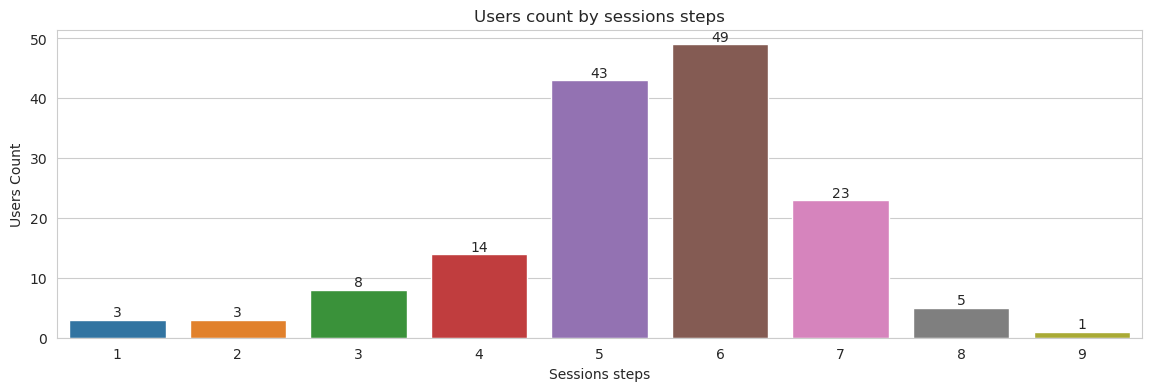

2024-04-08 18:14:06,593 - INFO - Mean Reciprocal Rank: 0.83
2024-04-08 18:14:06,596 - INFO - Mean Average Precision: 0.58
2024-04-08 18:14:06,599 - INFO - Recall: 0.7
2024-04-08 18:14:06,601 - INFO - Catalog Coverage: 0.12


In [23]:
evaluator.run()

**Step 4**: See metrics summary.

In [24]:
# evaluator.plot()